In [1]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
import pandas as pd
from typing import *
import numpy as np
from itertools import product
import math
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller


# Data

In [2]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
betas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gammas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

i_l = 17.417  # initial level
i_t = 0.465  # initial trend
i_s_mul = [1.09, 1.09, 1.32, 0.97, 1.03, 0.57, 0.63, 1.20, 1.72, 1.43, 0.51, 0.40]
i_s_add = [1.58, 1.58, 5.58, -0.41, 0.58, -7.41, -6.41, 3.58, 12.58, 7.58, -8.41, -10.41]

# Load and preprocess
df = pd.read_csv("data/o_sales.csv", parse_dates=["date"])
df = df.set_index("date")
df = df.asfreq("MS")

df_train = df[:-3]
df_test = df[-3:]

# Use the Series, not flattened NumPy array
df_train_one_d = df_train["quantity"]
df_test_one_d = df_test["quantity"]

# Define options for each component
errors = ["add", "mul"]
trends = [None, "add", "mul"]
seasonals = [None, "add", "mul"]
dampeds = [False, True]


# List to store valid configurations
# {error, trend, seasonal, damped_trend}
# error: "add", "mul"
# trend: "add", "mul", None
# seasonal: "add", "mul", None
# damped_trend: True, False
valid_configs = [
    {'error': 'add', 'trend': None, 'seasonal': None, 'damped_trend': False},
    {'error': 'add', 'trend': None, 'seasonal': 'add', 'damped_trend': False},
    {'error': 'add', 'trend': None, 'seasonal': 'mul', 'damped_trend': False},
    {'error': 'add', 'trend': 'add', 'seasonal': None, 'damped_trend': False},
    {'error': 'add', 'trend': 'add', 'seasonal': None, 'damped_trend': True},
    {'error': 'add', 'trend': 'add', 'seasonal': 'add', 'damped_trend': False},
    {'error': 'add', 'trend': 'add', 'seasonal': 'add', 'damped_trend': True},
    {'error': 'add', 'trend': 'add', 'seasonal': 'mul', 'damped_trend': False},
    {'error': 'add', 'trend': 'add', 'seasonal': 'mul', 'damped_trend': True},
    {'error': 'add', 'trend': 'mul', 'seasonal': None, 'damped_trend': False},
    {'error': 'add', 'trend': 'mul', 'seasonal': None, 'damped_trend': True},
    {'error': 'add', 'trend': 'mul', 'seasonal': 'add', 'damped_trend': False},
    {'error': 'add', 'trend': 'mul', 'seasonal': 'add', 'damped_trend': True},
    {'error': 'add', 'trend': 'mul', 'seasonal': 'mul', 'damped_trend': False},
    {'error': 'add', 'trend': 'mul', 'seasonal': 'mul', 'damped_trend': True},
    {'error': 'mul', 'trend': None, 'seasonal': 'add', 'damped_trend': False},
    {'error': 'mul', 'trend': None, 'seasonal': 'mul', 'damped_trend': False},
    {'error': 'mul', 'trend': 'add', 'seasonal': None, 'damped_trend': False},
    {'error': 'mul', 'trend': 'add', 'seasonal': None, 'damped_trend': True},
    {'error': 'mul', 'trend': 'add', 'seasonal': 'add', 'damped_trend': False},
    {'error': 'mul', 'trend': 'add', 'seasonal': 'add', 'damped_trend': True},
    {'error': 'mul', 'trend': 'add', 'seasonal': 'mul', 'damped_trend': False},
    {'error': 'mul', 'trend': 'add', 'seasonal': 'mul', 'damped_trend': True},
    {'error': 'mul', 'trend': 'mul', 'seasonal': None, 'damped_trend': False},
    {'error': 'mul', 'trend': 'mul', 'seasonal': None, 'damped_trend': True},
    {'error': 'mul', 'trend': 'mul', 'seasonal': 'add', 'damped_trend': False},
    {'error': 'mul', 'trend': 'mul', 'seasonal': 'add', 'damped_trend': True},
    {'error': 'mul', 'trend': 'mul', 'seasonal': 'mul', 'damped_trend': False},
    {'error': 'mul', 'trend': 'mul', 'seasonal': 'mul', 'damped_trend': True},
]

# Use this list if your data contains zeros or negative values
additive_configs = [
    {'error': 'add', 'trend': None, 'seasonal': None, 'damped_trend': False},
    {'error': 'add', 'trend': None, 'seasonal': 'add', 'damped_trend': False},
    {'error': 'add', 'trend': 'add', 'seasonal': None, 'damped_trend': False},
    {'error': 'add', 'trend': 'add', 'seasonal': None, 'damped_trend': True},
    {'error': 'add', 'trend': 'add', 'seasonal': 'add', 'damped_trend': False},
    {'error': 'add', 'trend': 'add', 'seasonal': 'add', 'damped_trend': True},
]

In [3]:
# Check for any NaN values in your training data
if df_train_one_d.isnull().values.any():
    print("NaN values were found in your training data!")
    
    # To see exactly which rows have NaN, you can do this:
    print("\nRows containing NaN:")
    print(df_train_one_d[df_train_one_d.isnull()])
else:
    print("No NaN values found in the training data.")

No NaN values found in the training data.


In [4]:

# --- Check the single value initial parameters ---
if math.isnan(i_l):
    print("WARNING: Your initial_level (i_l) is NaN.")
else:
    print("Initial level (i_l) is clean.")

if math.isnan(i_t):
    print("WARNING: Your initial_trend (i_t) is NaN.")
else:
    print("Initial trend (i_t) is clean.")

# --- Check the list initial parameters ---
if any(math.isnan(x) for x in i_s_mul):
    print("WARNING: Your multiplicative initial seasonal list (i_s_mul) contains a NaN.")
else:
    print("Multiplicative initial seasonal (i_s_mul) is clean.")

if any(math.isnan(x) for x in i_s_add):
    print("WARNING: Your additive initial seasonal list (i_s_add) contains a NaN.")
else:
    print("Additive initial seasonal (i_s_add) is clean.")

Initial level (i_l) is clean.
Initial trend (i_t) is clean.
Multiplicative initial seasonal (i_s_mul) is clean.
Additive initial seasonal (i_s_add) is clean.


In [5]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
def plot_acf_pacf(series):
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    pd.plotting.autocorrelation_plot(series, ax=ax[0])
    ax[0].set_title("Autocorrelation Function (ACF)")
    pd.plotting.lag_plot(series, lag=1, ax=ax[1])
    ax[1].set_title("Partial Autocorrelation Function (PACF)")
    plt.show()


Results of Dickey-Fuller Test:
Test Statistic                 -1.957184
p-value                         0.305656
#Lags Used                      5.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


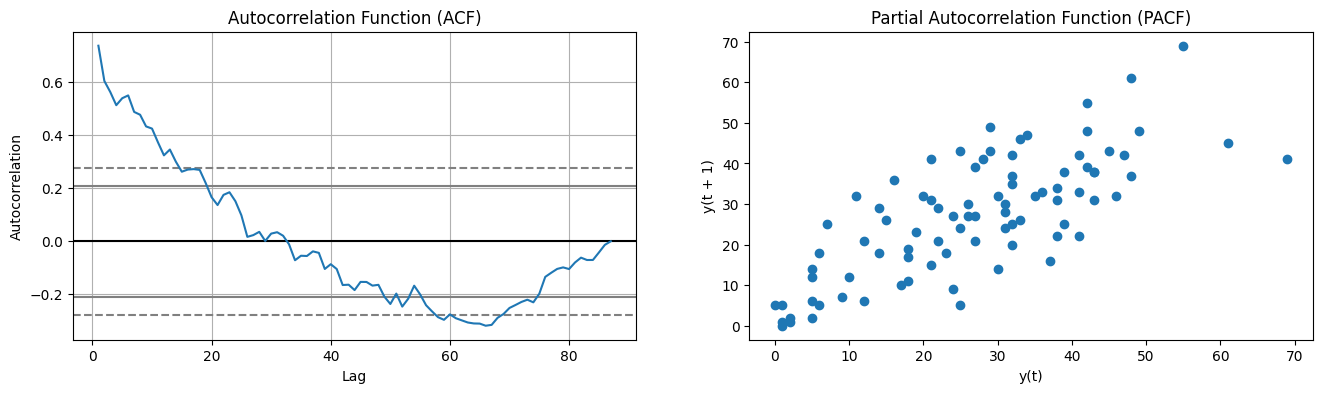

In [6]:
# Check ADF test for stationarity
adf_test(df)
# Plot ACF and PACF
plot_acf_pacf(df)

# Grid Search
Find the best model using looping and compare the MAPE, lowest MAPE is the best model.

Tuning parameters: alpha, beta, gamma using a grid search.

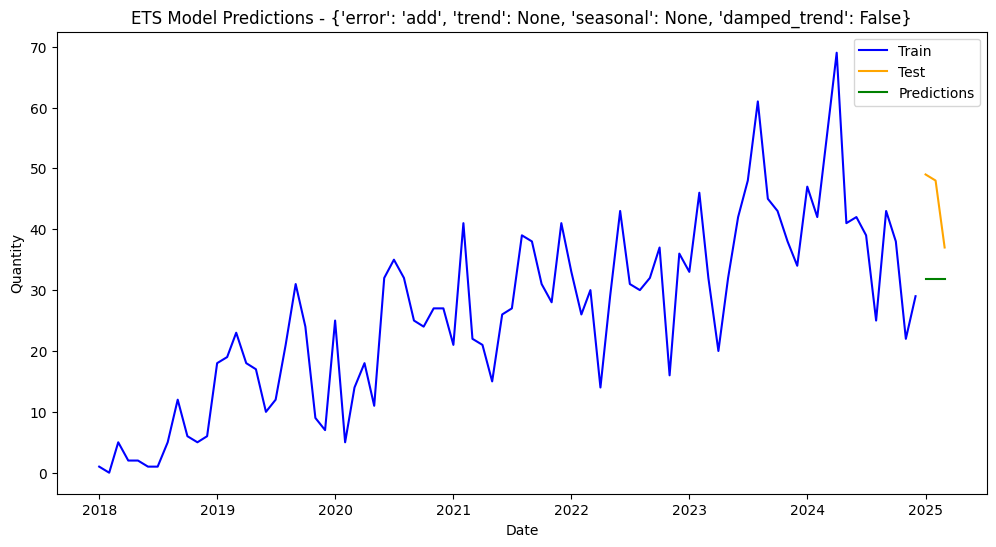

Config: {'error': 'add', 'trend': None, 'seasonal': None, 'damped_trend': False}, MAPE: 0.27711635807690765


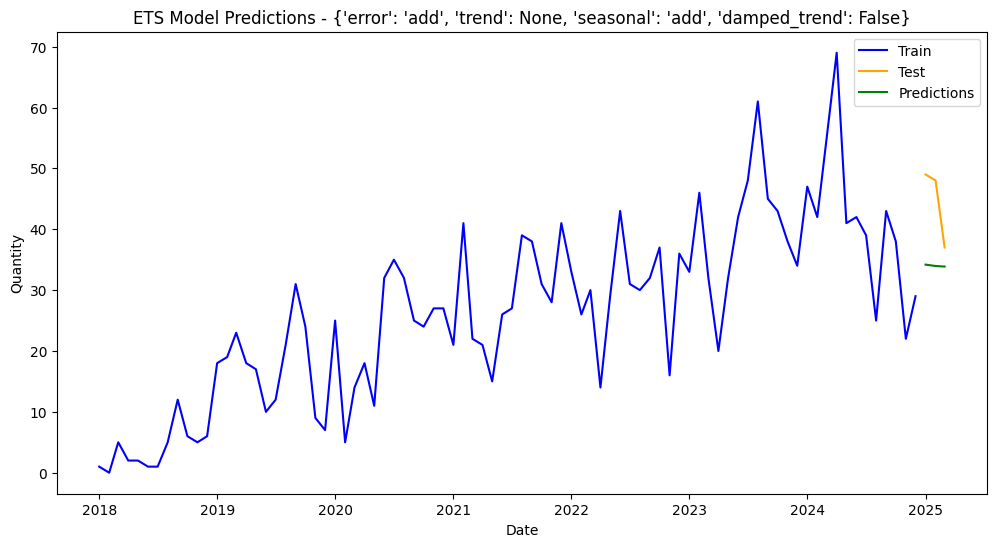

Config: {'error': 'add', 'trend': None, 'seasonal': 'add', 'damped_trend': False}, MAPE: 0.22646463495525251


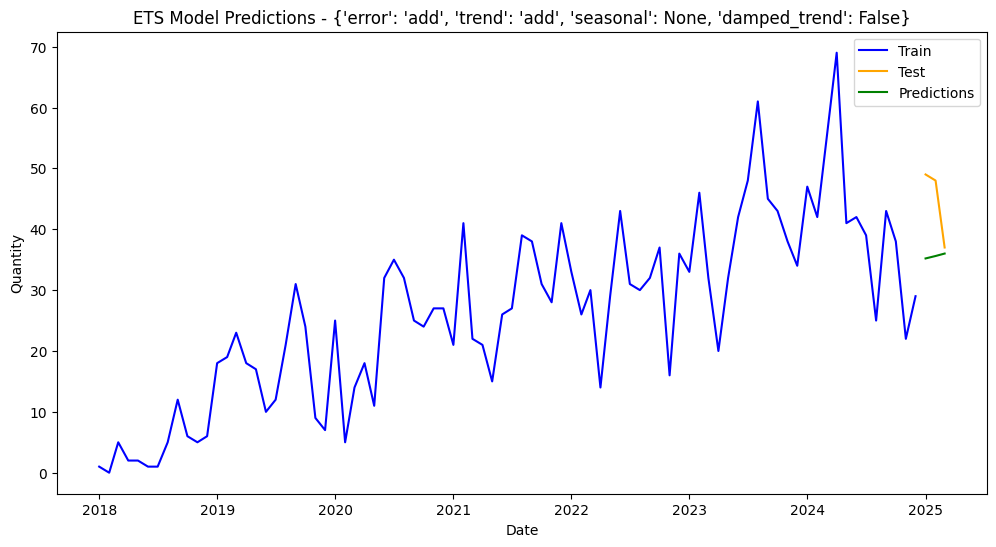

Config: {'error': 'add', 'trend': 'add', 'seasonal': None, 'damped_trend': False}, MAPE: 0.18889064874783978


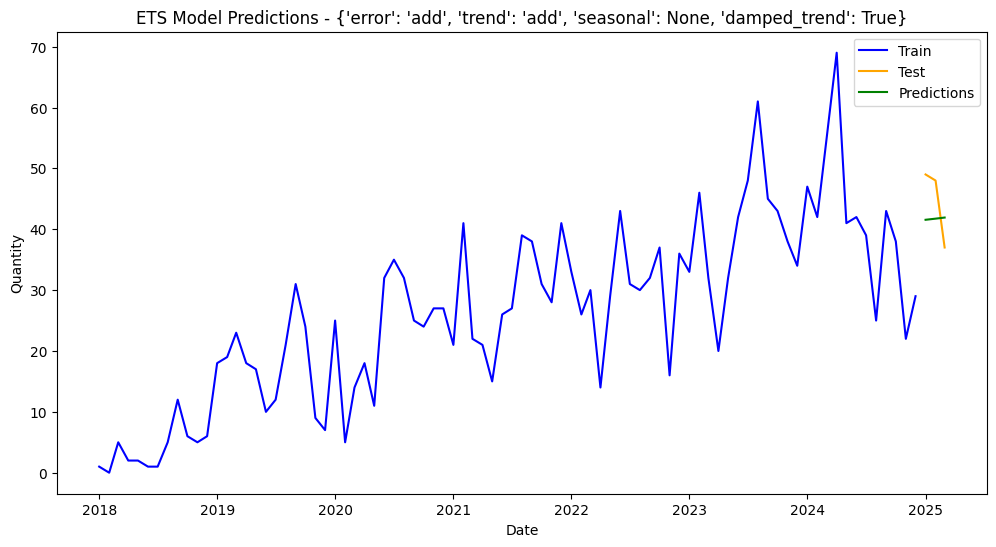

Config: {'error': 'add', 'trend': 'add', 'seasonal': None, 'damped_trend': True}, MAPE: 0.1384521659738915


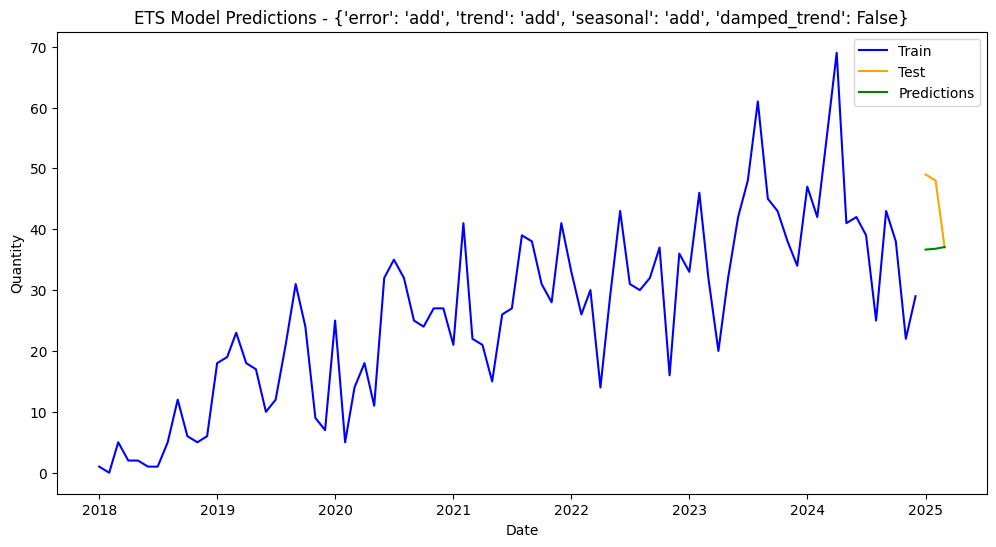

Config: {'error': 'add', 'trend': 'add', 'seasonal': 'add', 'damped_trend': False}, MAPE: 0.1625285581477605


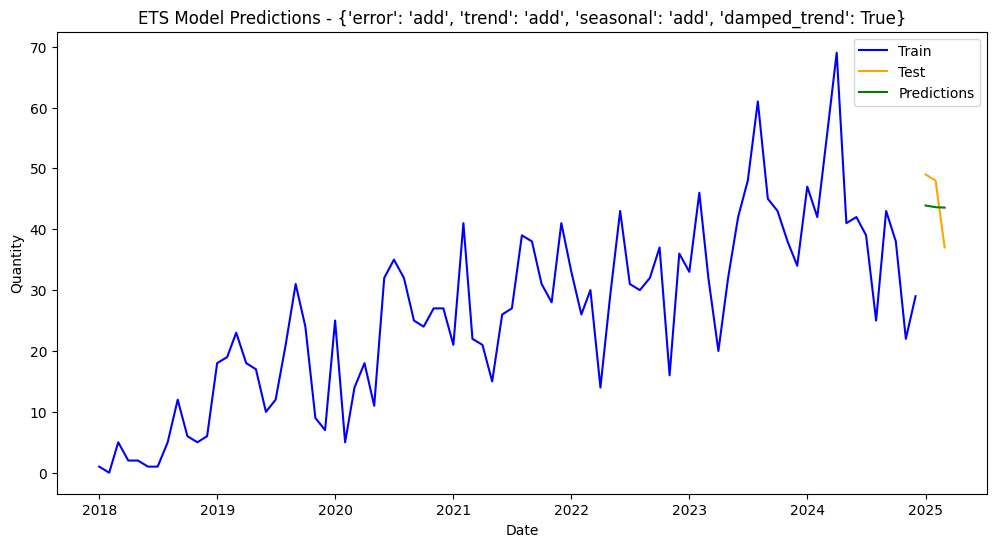

Config: {'error': 'add', 'trend': 'add', 'seasonal': 'add', 'damped_trend': True}, MAPE: 0.12409754455121015


In [ ]:
# start find best model configurations
best_mape = float("inf")
best_model = None
y_pred = None



for config in additive_configs:  # or valid_configs if you want to include multiplicative
    try:
        model = ETSModel(
            endog=df_train_one_d, 
            error=config["error"], 
            trend=config["trend"], 
            seasonal=config["seasonal"],
            damped_trend=config["damped_trend"], 
            seasonal_periods=12,
            initialization_method="estimated",
        )


        fit = model.fit(maxiter=100000)
        y_pred = fit.get_prediction(start=df_test_one_d.index[0], end=df_test_one_d.index[-1]).predicted_mean
        # Calculate and print MAPE
        print(f"Config: {config}, MAPE: {mean_absolute_percentage_error(df_test_one_d, y_pred)}")

        mape = mean_absolute_percentage_error(df_test_one_d, y_pred)

        if mape < best_mape:
            best_mape = mape
            best_model = fit
        
    except Exception as e:
        print(f"Error with config {config}: {e}")


                                 ETS Results                                  
Dep. Variable:               quantity   No. Observations:                   84
Model:                      ETS(AAdA)   Log Likelihood                -294.276
Date:                Thu, 12 Jun 2025   AIC                            626.553
Time:                        14:48:35   BIC                            672.738
Sample:                    01-01-2018   HQIC                           645.119
                         - 12-01-2024   Scale                           64.631
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.0001        nan        nan        nan         nan         nan
smoothing_trend          1e-08      0.006   1.74e-06      1.000      -0.011       0.011
smoothing_season

<Figure size 1200x600 with 0 Axes>

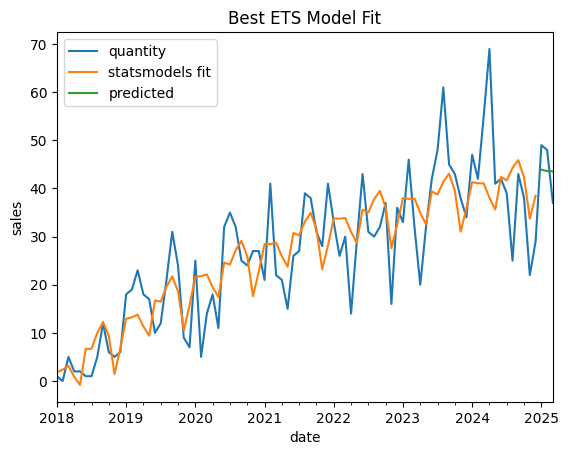

In [11]:
print(fit.summary())
print(f"MAPE: {best_mape}")
# Plot the best models
plt.figure(figsize=(12, 6))
df.plot(label="data")
fit.fittedvalues.plot(label="statsmodels fit")
y_pred.plot(label="predicted")
plt.title("Best ETS Model Fit")
plt.ylabel("sales")
plt.legend()
plt.show()